# 1. data statistics
## 1.1 
class,path,instance_nb 

mug,/groups/CESCA-CV/external/ShapeNetCore.v2/03797390,214

bottle,/groups/CESCA-CV/external/ShapeNetCore.v2/02876657,498

bowl,/groups/CESCA-CV/external/ShapeNetCore.v2/02880940,186

can,/groups/CESCA-CV/external/ShapeNetCore.v2/02946921,108

jar,/groups/CESCA-CV/external/ShapeNetCore.v2/03593526,596

knife,/groups/CESCA-CV/external/ShapeNetCore.v2/03624134,424

cellphone,/groups/CESCA-CV/external/ShapeNetCore.v2/02992529,831

camera,/groups/CESCA-CV/external/ShapeNetCore.v2/02942699,113

remote,/groups/CESCA-CV/external/ShapeNetCore.v2/04074963,66
## 1.2 
2772 meshes, 21K grasps
## 1.3 
Train/Val/Test

In [1]:
import os
import yaml
import numpy as np
import time
import h5py
import pickle

from random import randint, sample
import matplotlib 
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import __init__ 
from common.vis_utils import cam_equal_aspect_3d
from common import data_utils, handutils, vis_utils
from common.queries import (
    BaseQueries,
    TransQueries,
    one_query_in,
    no_query_in,
)
from tools.obman_vis import display_proj, display_pts, display_3d, visualize_img
%matplotlib notebook

In [2]:
!pwd
my_dir = '../../convolutional_occupancy_networks/dataset/media/full_viz/'
filenames = [f'{my_dir}/{filename}' for filename in os.listdir(my_dir)]
# print(filenames)
for i, filename in enumerate(filenames[1:2]):
    data = np.load(filename, allow_pickle=True).item()
    canon_pts =  data['canon_pts']
    boundary_pts = [np.min(canon_pts, axis=0), np.max(canon_pts, axis=0)]
    center_pt = (boundary_pts[0] + boundary_pts[1])/2
    length_bb = np.linalg.norm(boundary_pts[0] - boundary_pts[1])
    full_nocs = (canon_pts - center_pt.reshape(1, 3)) / length_bb + 0.5

/home/dragon/Dropbox/ICML2021/code/haoi-pose/tools


<IPython.core.display.Javascript object>


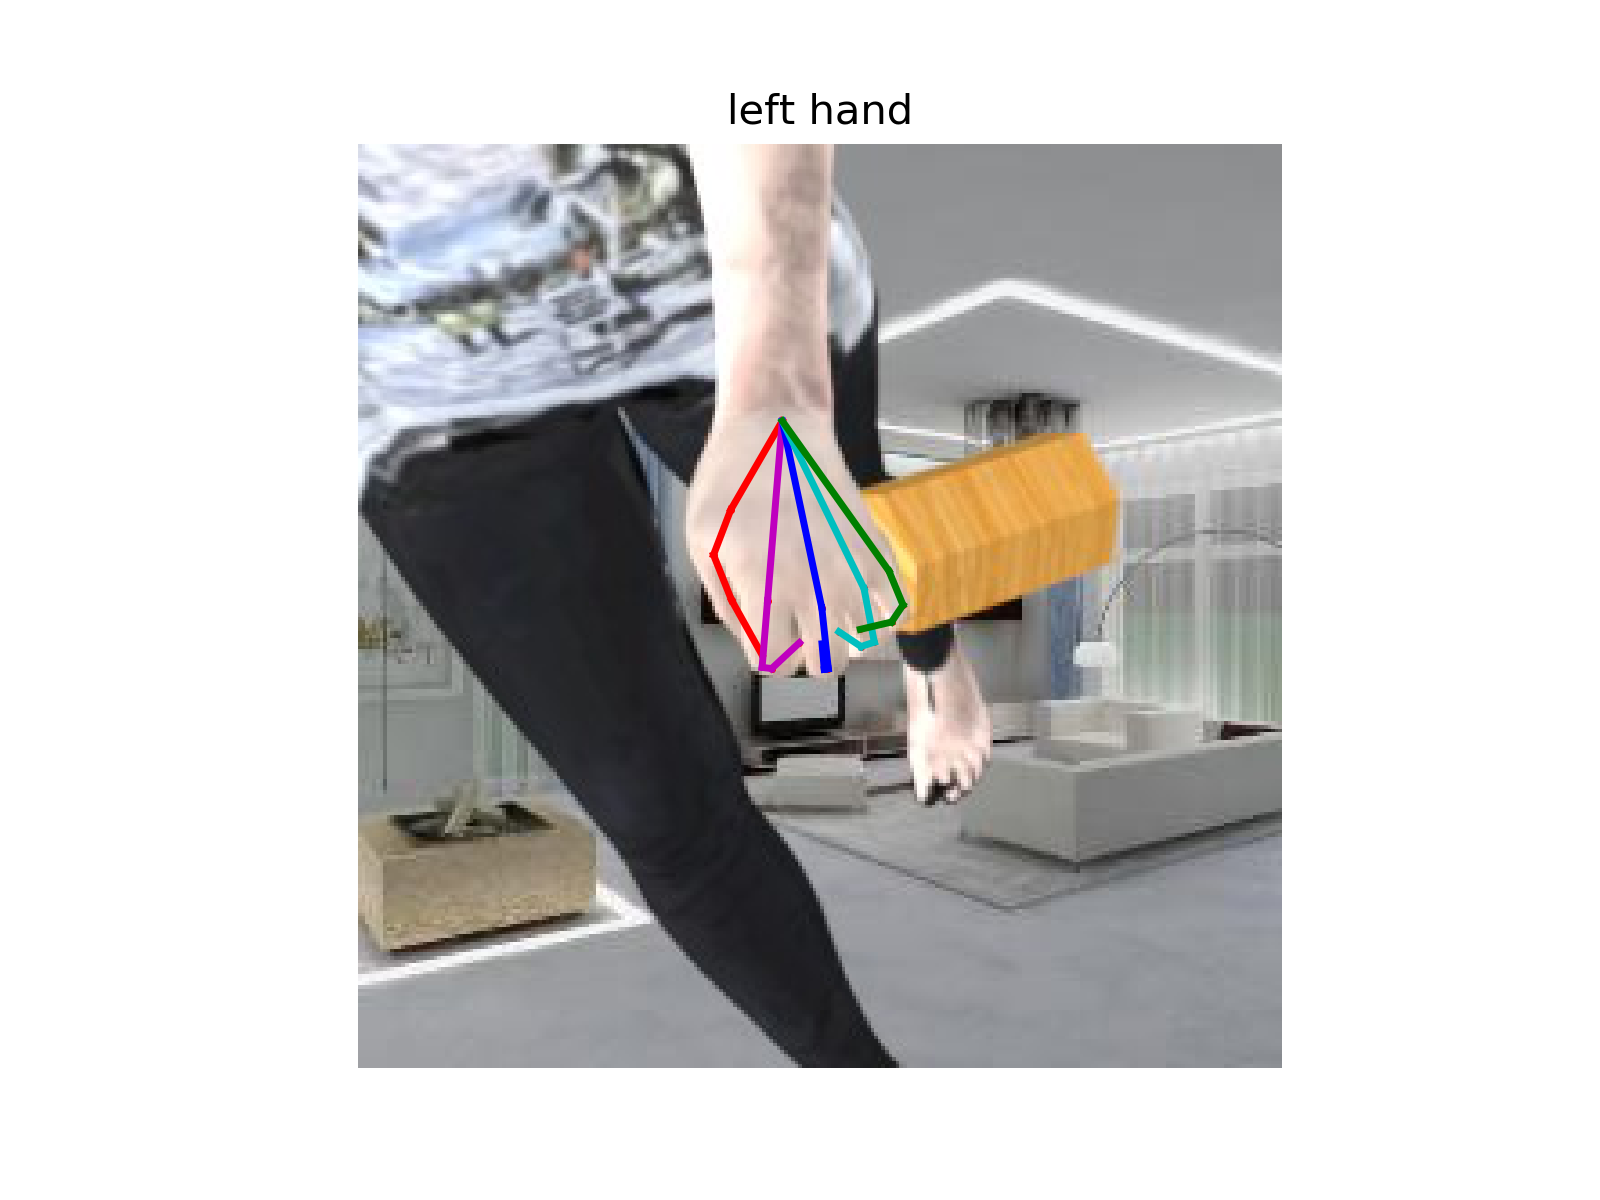

In [3]:
visualize_img(data)

dict_keys([<BaseQueries.sides: 'sides'>, <BaseQueries.images: 'images'>, <BaseQueries.joints2d: 'joints2d'>, <BaseQueries.joints3d: 'joints3d'>, <TransQueries.joints3d: 'joints3d'>, <TransQueries.verts3d: 'verts3d'>, <TransQueries.objpoints3d: 'objpoints3d'>, <TransQueries.images: 'images'>, <BaseQueries.depth: 'depth'>, <BaseQueries.pcloud: 'pcloud'>, 'full_pcloud', <BaseQueries.nocs: 'nocs'>, 'inputs', 'canon_pts', 'model_path', 'idx', 'points', 'points.occ'])


<IPython.core.display.Javascript object>


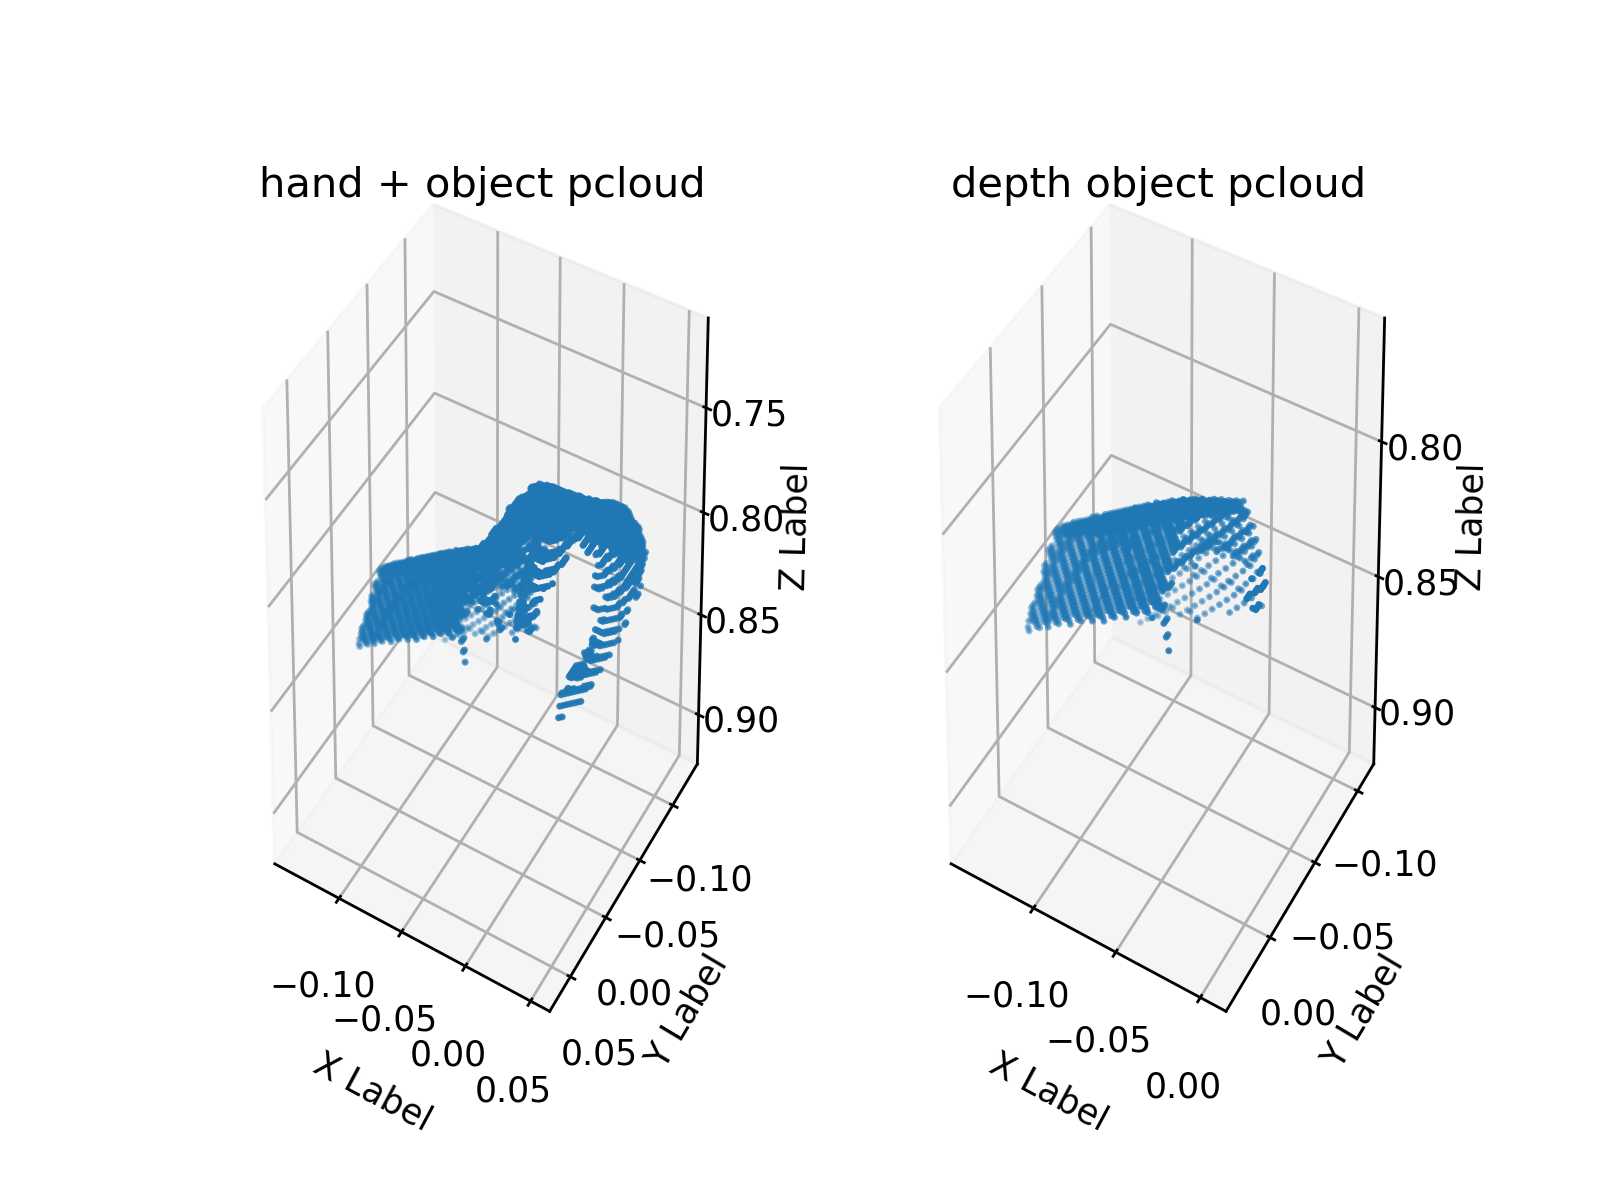

In [4]:
print(data.keys())
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
display_pts(ax, data['full_pcloud'], tn='hand + object pcloud')
ax = fig.add_subplot(122, projection='3d')
display_pts(ax, data[BaseQueries.pcloud], tn='depth object pcloud')
plt.show()

<IPython.core.display.Javascript object>


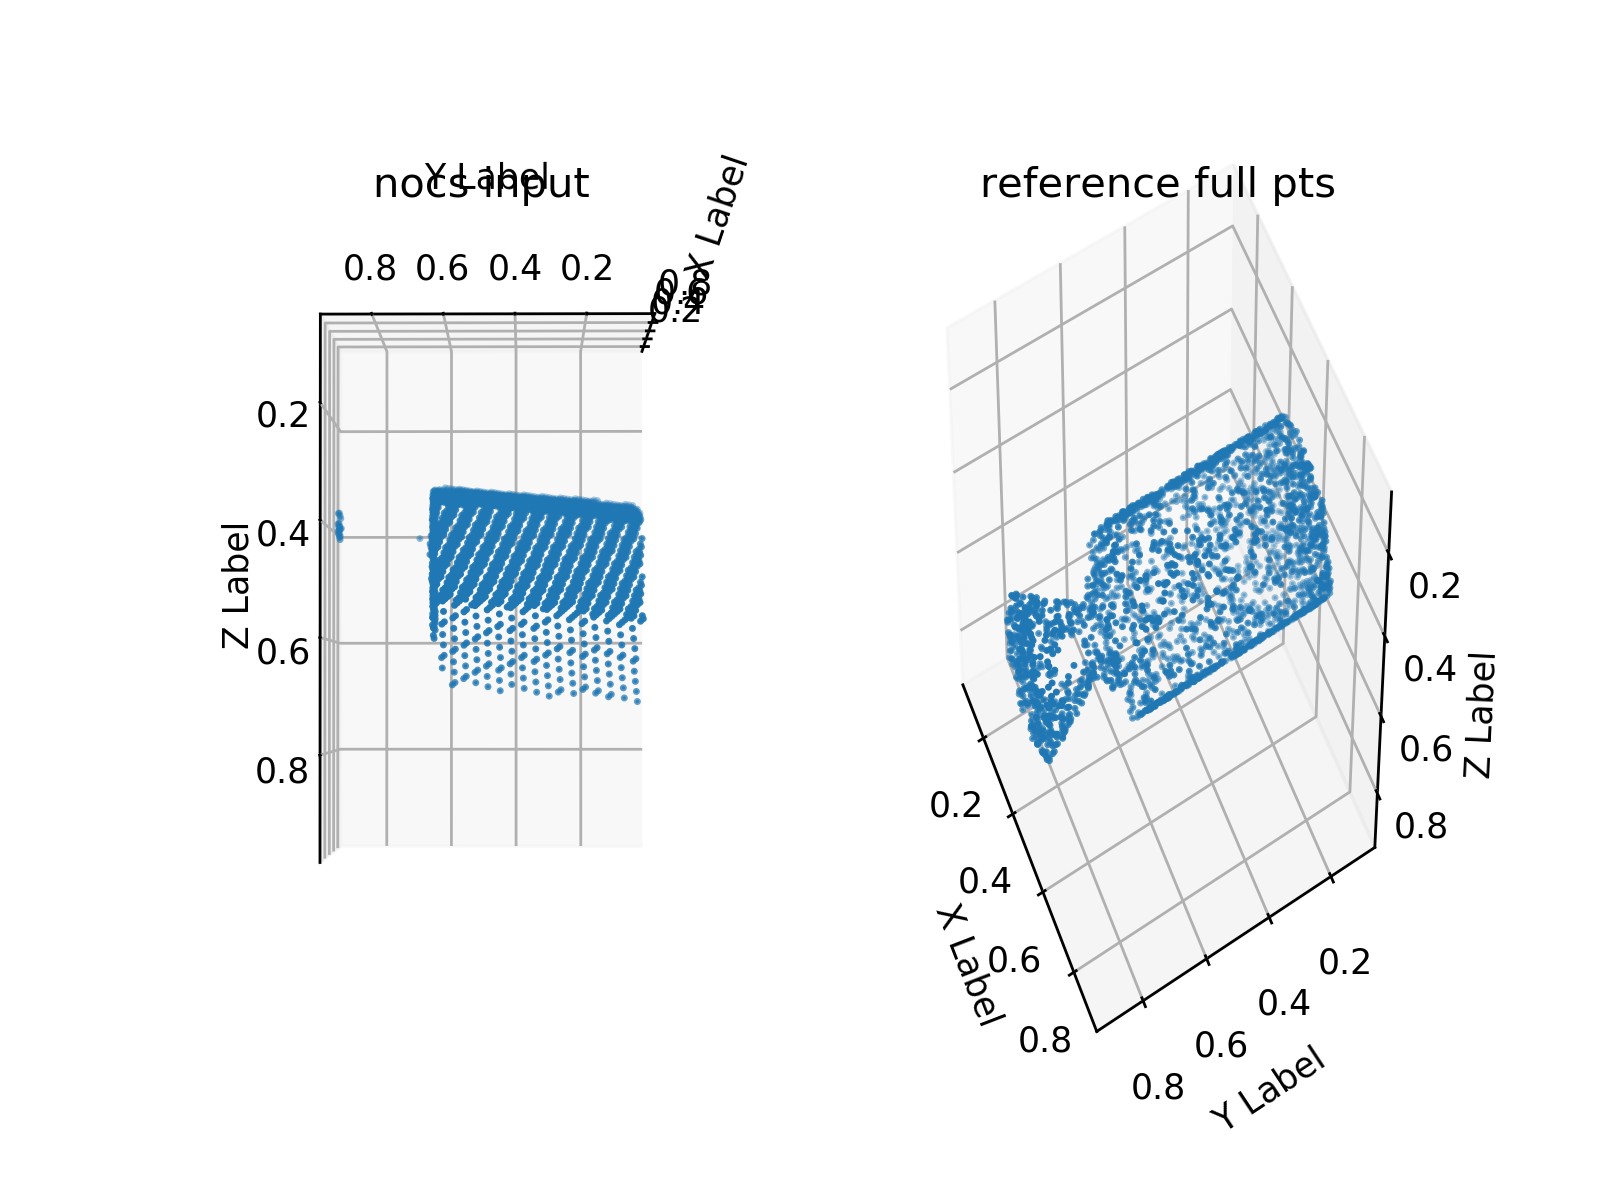

In [5]:
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
display_pts(ax, data[BaseQueries.nocs], tn='nocs input')
ax = fig.add_subplot(122, projection='3d')
display_pts(ax, full_nocs, tn='reference full pts')
plt.show()

In [23]:
print(data['model_path'])
# model_path = data['model_path']
model_path ='/home/dragon/Documents/ICML2021/external/ShapeNetCore.v2/02876657/10dff3c43200a7a7119862dbccbaa609/models/model_normalized.pkl'
model_path_obj = model_path.replace(".pkl", "_new.obj")
if os.path.exists(model_path):
    with open(model_path, "rb") as obj_f:
        mesh = pickle.load(obj_f)
elif os.path.exists(model_path_obj):
    with open(model_path_obj, "r") as m_f:
        print('loading ', model_path_obj)
        mesh = data_utils.fast_load_obj(m_f)[0]
v, f = mesh['vertices'], mesh['faces']
boundary_pts = [np.min(v, axis=0), np.max(v, axis=0)]
center_pt = (boundary_pts[0] + boundary_pts[1])/2
length_bb = np.linalg.norm(boundary_pts[0] - boundary_pts[1])
v = (v - center_pt.reshape(1, 3)) / length_bb + 0.5
print(v.shape)
print(f.shape)

/home/dragon/Documents/ICML2021/external/ShapeNetCore.v2/02876657/860c81982a1703d35a7ce4c111af2db/models/model_normalized.pkl
loading  /home/dragon/Documents/ICML2021/external/ShapeNetCore.v2/02876657/10dff3c43200a7a7119862dbccbaa609/models/model_normalized_new.obj
(233930, 3)
(467856, 3)


In [24]:
import igl
from meshplot import plot, subplot, interact
pts = np.random.rand(250000, 3) 
t0 = time.time()
# S, I, C = igl.signed_distance(pts, v, f, return_ormals=False)
t1 = time.time()
print(f'we have {t1-t0} seconds')
# print(min(S), S)
p = plot(v, f, shading={"point_size": 0.2})
p.add_points(pts,shading={"point_size": 0.02})

we have 3.981590270996094e-05 seconds


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.4999999…

1

In [25]:
import trimesh

def as_mesh(scene_or_mesh):
    """
    Convert a possible scene to a mesh.

    If conversion occurs, the returned mesh has only vertex and face data.
    """
    if isinstance(scene_or_mesh, trimesh.Scene):
        if len(scene_or_mesh.geometry) == 0:
            mesh = None  # empty scene
        else:
            # we lose texture information here
            mesh = trimesh.util.concatenate(
                tuple(trimesh.Trimesh(vertices=g.vertices, faces=g.faces)
                    for g in scene_or_mesh.geometry.values()))
    else:
        assert(isinstance(mesh, trimesh.Trimesh))
        mesh = scene_or_mesh
    return mesh


tm = trimesh.load(mesh)
b_min = np.min(np.array(tm.vertices), axis=0).reshape(1, 3) 
b_max = np.max(np.array(tm.vertices), axis=0).reshape(1, 3)
pts = np.random.rand(100000, 3)  - 0.5 + (b_max + b_min)/2

# # obj_file = '/home/dragon/Documents/ICML2021/external/ShapeNetCore.v2/02876657/860c81982a1703d35a7ce4c111af2db/models/model_normalized.obj'
# # tm = as_mesh(trimesh.load(obj_file))
# print(tm.is_watertight)
# is_contain = trimesh.ray.ray_triangle.RayMeshIntersector(tm)
# mask = is_contain.contains_points(pts)
# print('inside pts: ', pts[mask].shape[0])
# p = plot(tm.vertices, shading={"point_size": 0.2})
# # p.add_mesh(v, f)
# p.add_points(pts[mask],shading={"point_size": 0.05})
# p.add_points(np.array([[0, 0, 0]]),shading={"point_size": 0.5})

In [27]:
import sys
import __init__ 
from utils.external.libmesh import check_mesh_contains
t0 = time.time()
print(tm.is_watertight)
occupancies = check_mesh_contains(tm, pts)
print(occupancies)
mask = np.where(occupancies>0)[0]
t1 = time.time()
print(f'it takes {t1-t0} sec for {pts[mask].shape[0]} in {mask.shape[0]} pts')
p = plot(tm.vertices, shading={"point_size": 0.01})
# p.add_mesh(v, f)
p.add_points(pts[mask],shading={"point_size": 0.05})
# # Compress
# if args.float16:
#     dtype = np.float16
# else:
#     dtype = np.float32

# points = points.astype(dtype)

# if args.packbits:
#     occupancies = np.packbits(occupancies)

# print('Writing points: %s' % filename)
# np.savez(filename, points=points, occupancies=occupancies,
#          loc=loc, scale=scale)

False
[False False False ... False False  True]
it takes 0.2717256546020508 sec for 9251 in 9251 pts


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0028174…

1

In [28]:
import numpy as np
import mesh_to_sdf
from mesh_to_sdf import get_surface_point_cloud, scale_to_unit_sphere
import trimesh
import skimage, skimage.measure
import os

mesh = trimesh.load('../../mesh_to_sdf/example/chair.obj')
# mesh = scale_to_unit_sphere(mesh)

print("Scanning...")
t0 = time.time()
cloud = get_surface_point_cloud(mesh, surface_point_method='scan', scan_count=20, scan_resolution=400)
t1 = time.time()
print(t1-t0)
cloud.show()

# os.makedirs("test", exist_ok=True)
# for i, scan in enumerate(cloud.scans):
#     scan.save("test/scan_{:d}.png".format(i))

# print("Voxelizing...")
# voxels = cloud.get_voxels(128, use_depth_buffer=True)

# print("Creating a mesh using Marching Cubes...")
# vertices, faces, normals, _ = skimage.measure.marching_cubes_lewiner(voxels, level=0)
# mesh = trimesh.Trimesh(vertices=vertices, faces=faces, vertex_normals=normals)
# mesh.show()

Scanning...
0.7025778293609619
